In [25]:
# Import necessary libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define device
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# Step 1: Load and preprocess the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 64

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Step 2: Define a simple CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 8 * 8)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize the model, loss function, and optimizer
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 3: Train the model
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}")

# Step 4: Evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

# Train and evaluate the model
train_model(model, train_loader, criterion, optimizer, epochs=10)
evaluate_model(model, test_loader)


Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10, Loss: 1.6572
Epoch 2/10, Loss: 1.3630
Epoch 3/10, Loss: 1.2211
Epoch 4/10, Loss: 1.1332
Epoch 5/10, Loss: 1.0794
Epoch 6/10, Loss: 1.0318
Epoch 7/10, Loss: 1.0036
Epoch 8/10, Loss: 0.9755
Epoch 9/10, Loss: 0.9462
Epoch 10/10, Loss: 0.9333
Test Accuracy: 69.56%


Using device: mps
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/100, Loss: 1.4832, Test Accuracy: 51.07%
Epoch 2/100, Loss: 1.7577, Test Accuracy: 47.33%
Epoch 3/100, Loss: 1.2854, Test Accuracy: 59.47%
Epoch 4/100, Loss: 1.0717, Test Accuracy: 67.26%
Epoch 5/100, Loss: 0.9717, Test Accuracy: 70.95%
Epoch 6/100, Loss: 0.8783, Test Accuracy: 72.28%
Epoch 7/100, Loss: 0.7661, Test Accuracy: 75.53%
Epoch 8/100, Loss: 0.7119, Test Accuracy: 76.58%
Epoch 9/100, Loss: 0.6549, Test Accuracy: 80.52%
Epoch 10/100, Loss: 0.5945, Test Accuracy: 82.14%
Epoch 11/100, Loss: 0.5770, Test Accuracy: 82.33%
Epoch 12/100, Loss: 0.5260, Test Accuracy: 83.11%
Epoch 13/100, Loss: 0.5153, Test Accuracy: 81.39%
Epoch 14/100, Loss: 0.4933, Test Accuracy: 83.53%
Epoch 15/100, Loss: 0.4722, Test Accuracy: 84.70%
Epoch 16/100, Loss: 0.4688, Test Accuracy: 83.16%
Epoch 17/100, Loss: 0.4518, Test Accuracy: 82.87%
Epoch 18/100, Loss: 0.4512, Test Accuracy: 84.16%
Epoch 19/100, L

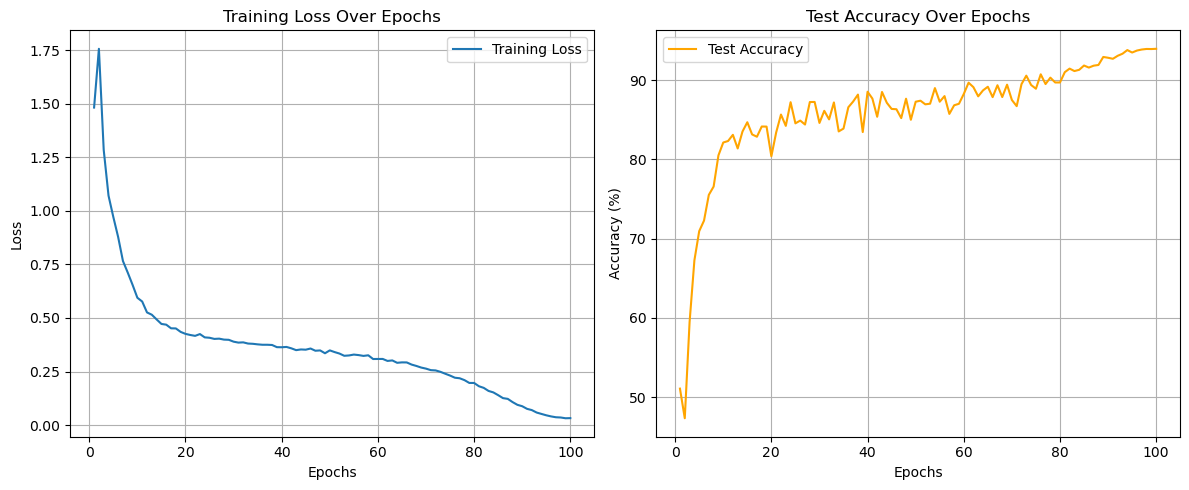

In [22]:
# Import necessary libraries
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
import matplotlib.pyplot as plt

# Define device
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

# Step 1: Load and preprocess the CIFAR-10 dataset
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  # Convert image to PyTorch tensor first
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.1), ratio=(0.3, 3.3)),  # Now apply RandomErasing
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

batch_size = 128

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Step 2: Define the improved CNN with residual connections
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = nn.ReLU()(out)
        return out

class DeepResidualCNN(nn.Module):
    def __init__(self):
        super(DeepResidualCNN, self).__init__()
        self.layer1 = self._make_layer(3, 64, stride=1)
        self.layer2 = self._make_layer(64, 128, stride=2)
        self.layer3 = self._make_layer(128, 256, stride=2)
        self.layer4 = self._make_layer(256, 512, stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, 10)

    def _make_layer(self, in_channels, out_channels, stride):
        layers = [
            ResidualBlock(in_channels, out_channels, stride),
            ResidualBlock(out_channels, out_channels, stride=1),
        ]
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Initialize the model, loss function, optimizer, and scheduler
model = DeepResidualCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=100)

# Step 3: Train the model with added logging for loss and accuracy
def train_model_with_logging(model, train_loader, test_loader, criterion, optimizer, scheduler, epochs=100):
    model.train()
    train_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            running_loss += loss.item()
        
        # Log the average loss for the epoch
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Evaluate the model on the test set
        accuracy = evaluate_model(model, test_loader)
        test_accuracies.append(accuracy)

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%")
    
    return train_losses, test_accuracies

# Step 4: Evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Train and evaluate the model, logging metrics
train_losses, test_accuracies = train_model_with_logging(
    model, train_loader, test_loader, criterion, optimizer, scheduler, epochs=100
)

# Plot training loss and test accuracy
def plot_metrics(train_losses, test_accuracies):
    epochs = range(1, len(train_losses) + 1)

    # Plot training loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.grid(True)
    plt.legend()

    # Plot test accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, test_accuracies, label='Test Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Test Accuracy Over Epochs')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Visualize metrics
plot_metrics(train_losses, test_accuracies)
